<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Modelo de lenguaje con tokenización por palabras

### Consigna
- Seleccionar un corpus de texto sobre el cual entrenar el modelo de lenguaje.
- Realizar el pre-procesamiento adecuado para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.
- Proponer arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.
- Con el o los modelos que consideren adecuados, generar nuevas secuencias a partir de secuencias de contexto con las estrategias de greedy search y beam search determístico y estocástico. En este último caso observar el efecto de la temperatura en la generación de secuencias.


### Sugerencias
- Durante el entrenamiento, guiarse por el descenso de la perplejidad en los datos de validación para finalizar el entrenamiento. Para ello se provee un callback.
- Explorar utilizar SimpleRNN (celda de Elman), LSTM y GRU.
- rmsprop es el optimizador recomendado para la buena convergencia. No obstante se pueden explorar otros.


In [62]:
import io
import math
import pickle
import random

import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import LSTM, Bidirectional, Dense, Dropout, Embedding
from keras.models import Sequential
from keras.utils import to_categorical
from scipy.special import softmax
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# Usaremos las utilidades de procesamiento de textos y secuencias de Keras
from tensorflow.keras.preprocessing.text import \
    Tokenizer  # equivalente a ltokenizer de nltk
from tensorflow.keras.preprocessing.text import \
    text_to_word_sequence  # equivalente a word_tokenize de nltk
from tensorflow.keras.utils import pad_sequences  # se utilizará para padding

### Datos
Se utilizará un dataset ligero de spam de emails: https://www.kaggle.com/datasets/tapakah68/email-spam-classification

Primero descomprimimos el fichero y leemos los datos

In [7]:
!unzip -q email_spam.zip

"unzip" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [8]:
dataframe_spam = pd.read_csv("email_spam.csv", encoding='latin-1')
# Reemplazar '\r' por un string vacío en todas las columnas
dataframe_spam = dataframe_spam.replace({'\r': ' ', '\n': ' ', "\?\?": ''}, regex=True)
dataframe_spam.head(300)

,title,text,type
0,the secrets to SUCCESS,"Hi James, Have you claim your complimentary g...",spam
1,You Earned 500 GCLoot Points,"alt_text Congratulations, you just earned 500...",not spam
2,Your GitHub launch code,"Here's your GitHub launch code, @Mortyj420! ...",not spam
3,[The Virtual Reward Center] Re: ** Clarifications,"Hello, Thank you for contacting the Virtual ...",not spam
4,"10-1 MLB Expert Inside, Plus Everything You Ne...","Hey Prachanda Rawal, Today's newsletter is Ja...",spam
...,...,...,...
79,Your application for the position of Child Pr...,"Dear Maryam, I would like to thank you fo...",not spam
80,Your Kilimall Account is Ready - Shopping Now!,"Dear Customer, Welcome to Kilimall, Thanks so...",not spam
81,Your Steam account: Access from new web or mob...,"Dear vladis163rus, Here is the Steam Guard cod...",not spam
82,Your uploaded document is rejected,View In Browser | Log in Skrill logo Mone...,not spam


Obtenemos el texto de interés. En este caso, el contenido de los tweets.

In [9]:
dataframe_spam_title = dataframe_spam["title"]
dataframe_spam_text = dataframe_spam["text"]
dataframe_spam = pd.DataFrame({'Text': dataframe_spam_title + ' ' + dataframe_spam_text})
dataframe_spam.head(300)

,Text
0,"the secrets to SUCCESS Hi James, Have you cl..."
1,You Earned 500 GCLoot Points alt_text Congra...
2,Your GitHub launch code Here's your GitHub la...
3,[The Virtual Reward Center] Re: ** Clarificati...
4,"10-1 MLB Expert Inside, Plus Everything You Ne..."
...,...
79,Your application for the position of Child Pr...
80,Your Kilimall Account is Ready - Shopping Now!...
81,Your Steam account: Access from new web or mob...
82,Your uploaded document is rejected View In Bro...


Una de las primeras decisiones que hay que tomar es el tamaño de contexto de tokens máximo que puede consumir el modelo. Este podría ser un hiperparámetro del problema.

Para elegir el tamaño de contexto máximo para este problema se puede explorar el dataset, para ello:
- se consideran las palabras como términos.
- se segmentará el texto de todos los tweets del dataset y ses explorará la cantidad de términos presentes.



In [10]:
print("Cantidad de documentos:", dataframe_spam.shape[0])

Cantidad de documentos: 84


### Elegir el tamaño del contexto

In [11]:
# cada tweet lo guardamos en una lista
text = list(dataframe_spam['Text'])
text

[" the secrets to SUCCESS Hi James,  Have you claim your complimentary gift yet?  I've compiled in here a special astrology gift that predicts everything about you in the future?  This is your enabler to take the correct actions now.  >> Click here to claim your copy now >>  Claim yours now, and thank me later.   Love, Heather",
 ' You Earned 500 GCLoot Points  alt_text Congratulations, you just earned 500   You completed the following offer:  View Points History To stop recieving notifications when you earn points, please visit your profile and click "Preferences" to change your setting.  Room 1203, 12th Floor, Tower 3  China Hong Kong City, 33 Canton Road  Tsim Sha Tsui, Kowloon, Hong Kong  Unsubscribe',
 " Your GitHub launch code Here's your GitHub launch code, @Mortyj420!   an octocat standing next to a rocket  Continue signing up for GitHub by entering the code below:  63024610   Open GitHub",
 '[The Virtual Reward Center] Re: ** Clarifications Hello,   Thank you for contacting th

In [12]:
# segmentamos el texto con la utilidad de Keras
segmented_sentences = [text_to_word_sequence(sentence) for sentence in text]

In [13]:
text[0]

" the secrets to SUCCESS Hi James,  Have you claim your complimentary gift yet?  I've compiled in here a special astrology gift that predicts everything about you in the future?  This is your enabler to take the correct actions now.  >> Click here to claim your copy now >>  Claim yours now, and thank me later.   Love, Heather"

In [14]:
segmented_sentences[0]

['the',
 'secrets',
 'to',
 'success',
 'hi',
 'james',
 'have',
 'you',
 'claim',
 'your',
 'complimentary',
 'gift',
 'yet',
 "i've",
 'compiled',
 'in',
 'here',
 'a',
 'special',
 'astrology',
 'gift',
 'that',
 'predicts',
 'everything',
 'about',
 'you',
 'in',
 'the',
 'future',
 'this',
 'is',
 'your',
 'enabler',
 'to',
 'take',
 'the',
 'correct',
 'actions',
 'now',
 'click',
 'here',
 'to',
 'claim',
 'your',
 'copy',
 'now',
 'claim',
 'yours',
 'now',
 'and',
 'thank',
 'me',
 'later',
 'love',
 'heather']

In [15]:
# calculamos la longitud de cada secuencia
length_sentences = [len(sentence) for sentence in segmented_sentences]

(array([23., 26., 18.,  5.,  4.,  1.,  1.,  1.,  2.,  0.,  1.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([   4. ,   60.1,  116.2,  172.3,  228.4,  284.5,  340.6,  396.7,
         452.8,  508.9,  565. ,  621.1,  677.2,  733.3,  789.4,  845.5,
         901.6,  957.7, 1013.8, 1069.9, 1126. ]),
 <BarContainer object of 20 artists>)

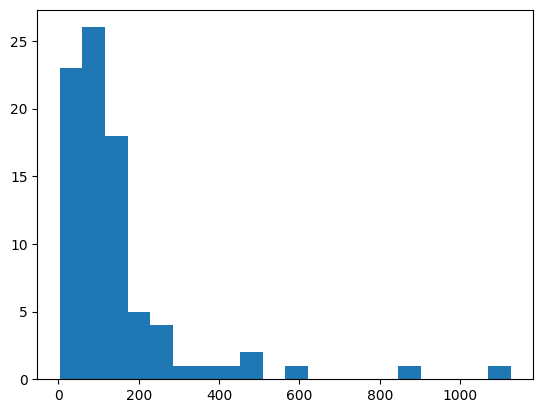

In [16]:
# podemos ver su distribución
plt.hist(length_sentences,bins=20)

Por la naturaleza de los emails, es muy probable que no se utilicen signos de puntuacion a menudo, por lo que hay que elegir un tamaño a mano. 50 palabras parece razonable

In [17]:
# a partir de la distribución de longitudes de secuencias elegimos algún criterio
# para determinar el máximo tamaño de contexto. En este caso es un percentil, pero
# otros criterios también pueden ser válidos con la justificación adecuada.
# También puede ser una selección "a mano"

# el -1 es porque el último token será el target
# max_context_size = int(np.percentile(length_sentences, 95)-1)

# max_context_size = int(np.ceil(np.mean(length_sentences))) # criterio de media
max_context_size = 50 # criterio a mano
print(f'max_context_size: {max_context_size}')

max_context_size: 50


###  Tokenizar

In [18]:
# instanciamos el tokenizador
tok = Tokenizer()

# El tokenizer "aprende" las palabras que se usaran
# Se construye (fit) una vez por proyecto, se aplica N veces (tal cual un encoder)
# El token 0 es reservado y no es asignado. Se utiliza para designar a palabras
# fuera del vocabulario aprendido
tok.fit_on_texts(segmented_sentences)

# Convertimos las palabras a números
# entran palabras -> salen números
tokenized_sentences = tok.texts_to_sequences(segmented_sentences)

In [19]:
tokenized_sentences[0]

[1,
 1482,
 2,
 493,
 99,
 862,
 20,
 3,
 621,
 5,
 1483,
 182,
 622,
 863,
 1484,
 6,
 32,
 7,
 208,
 1485,
 182,
 19,
 1486,
 623,
 41,
 3,
 6,
 1,
 321,
 11,
 9,
 5,
 1487,
 2,
 86,
 1,
 864,
 1488,
 50,
 43,
 32,
 2,
 621,
 5,
 1489,
 50,
 621,
 494,
 50,
 4,
 76,
 183,
 1490,
 394,
 1491]

In [20]:
segmented_sentences[0]

['the',
 'secrets',
 'to',
 'success',
 'hi',
 'james',
 'have',
 'you',
 'claim',
 'your',
 'complimentary',
 'gift',
 'yet',
 "i've",
 'compiled',
 'in',
 'here',
 'a',
 'special',
 'astrology',
 'gift',
 'that',
 'predicts',
 'everything',
 'about',
 'you',
 'in',
 'the',
 'future',
 'this',
 'is',
 'your',
 'enabler',
 'to',
 'take',
 'the',
 'correct',
 'actions',
 'now',
 'click',
 'here',
 'to',
 'claim',
 'your',
 'copy',
 'now',
 'claim',
 'yours',
 'now',
 'and',
 'thank',
 'me',
 'later',
 'love',
 'heather']

### Organizando y estructurando el dataset

En este punto tenemos en la variable `tokenized_sentences` los versos tokenizados. Vamos a quedarnos con un conjunto de validación que utilizaremos para medir la calidad de la generación de secuencias con la métrica de Perplejidad.

In [21]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, tokenized_sentences, test_size=0.2, random_state=42)

Vamos a splitear las oraciones que tienen tamaño mayor al contexto máximo, para generarnos más secuencias de entrenamiento. Este paso puede obviarse si el tamaño de contexto máximo es muy grande.

In [22]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)


In [23]:
print(f"Aumentado el numero de tokens de {len(tokenized_sentences_train)} a {len(tok_sent)}")

Aumentado el numero de tokens de 67 a 5188


Ahora aumentamos los datos aprovechando que de una secuencia grande se pueden generar varias más pequeñas:

In [24]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))


In [25]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [26]:
train_seqs.shape

(259105, 51)

In [27]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

Nótese que estamos estructurando el problema de aprendizaje como *many-to-many*:

Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]

Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

De manera que la red tiene que aprender que su salida deben ser los tokens desplazados en una posición y un nuevo token predicho (el N+1).

La ventaja de estructurar el aprendizaje de esta manera es que para cada token de target se propaga una señal de gradiente por el grafo de cómputo recurrente, que es mejor que estructurar el problema como *many-to-one* en donde sólo una señal de gradiente se propaga.

In [28]:
y.shape

(259105, 50)

In [29]:
# Palabras del vocabulario
tok.index_word

{1: 'the',
 2: 'to',
 3: 'you',
 4: 'and',
 5: 'your',
 6: 'in',
 7: 'a',
 8: 'for',
 9: 'is',
 10: 'of',
 11: 'this',
 12: 'on',
 13: 'our',
 14: 'we',
 15: 'are',
 16: 'or',
 17: 'i',
 18: 'with',
 19: 'that',
 20: 'have',
 21: 'if',
 22: 'from',
 23: 'will',
 24: 'be',
 25: 'more',
 26: 'as',
 27: 'account',
 28: 'com',
 29: 'email',
 30: 'company',
 31: 'please',
 32: 'here',
 33: 'by',
 34: 'all',
 35: 'at',
 36: 'it',
 37: 'new',
 38: '2023',
 39: 'can',
 40: 'logo',
 41: 'about',
 42: 'us',
 43: 'click',
 44: '1',
 45: 'an',
 46: 'amazon',
 47: 'service',
 48: 'customer',
 49: 'has',
 50: 'now',
 51: 'just',
 52: 'so',
 53: 'how',
 54: 'was',
 55: 'any',
 56: '000',
 57: 'their',
 58: 'â\x80¢',
 59: 'do',
 60: 'not',
 61: 'privacy',
 62: 'use',
 63: 'like',
 64: 'time',
 65: 'address',
 66: 'up',
 67: 'out',
 68: '10',
 69: 'terms',
 70: '4',
 71: 'work',
 72: 'project',
 73: 'may',
 74: 'read',
 75: 'pt',
 76: 'thank',
 77: 'what',
 78: 'team',
 79: 'been',
 80: 'information',


In [30]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

2998

In [31]:
# El índice para cada palabra
# El sistema las ordena de las más populares a las menos populares
print(tok.word_index)

{'the': 1, 'to': 2, 'you': 3, 'and': 4, 'your': 5, 'in': 6, 'a': 7, 'for': 8, 'is': 9, 'of': 10, 'this': 11, 'on': 12, 'our': 13, 'we': 14, 'are': 15, 'or': 16, 'i': 17, 'with': 18, 'that': 19, 'have': 20, 'if': 21, 'from': 22, 'will': 23, 'be': 24, 'more': 25, 'as': 26, 'account': 27, 'com': 28, 'email': 29, 'company': 30, 'please': 31, 'here': 32, 'by': 33, 'all': 34, 'at': 35, 'it': 36, 'new': 37, '2023': 38, 'can': 39, 'logo': 40, 'about': 41, 'us': 42, 'click': 43, '1': 44, 'an': 45, 'amazon': 46, 'service': 47, 'customer': 48, 'has': 49, 'now': 50, 'just': 51, 'so': 52, 'how': 53, 'was': 54, 'any': 55, '000': 56, 'their': 57, 'â\x80¢': 58, 'do': 59, 'not': 60, 'privacy': 61, 'use': 62, 'like': 63, 'time': 64, 'address': 65, 'up': 66, 'out': 67, '10': 68, 'terms': 69, '4': 70, 'work': 71, 'project': 72, 'may': 73, 'read': 74, 'pt': 75, 'thank': 76, 'what': 77, 'team': 78, 'been': 79, 'information': 80, 'get': 81, 'they': 82, 'app': 83, 'see': 84, 'other': 85, 'take': 86, 'one': 87

In [32]:
# Cantidad de veces quea aparece cada palabra en cada "documento"
# (1 documento = 1 caso de entrada)
print(tok.word_docs)

defaultdict(<class 'int'>, {'thank': 18, 'this': 46, 'a': 59, 'actions': 1, 'to': 75, 'hi': 14, 'the': 72, 'astrology': 1, 'is': 43, 'correct': 2, 'you': 67, 'click': 17, 'complimentary': 1, 'yet': 3, 'special': 5, 'now': 15, 'in': 50, 'here': 21, 'secrets': 1, 'everything': 2, 'future': 6, 'copy': 1, 'yours': 4, 'compiled': 1, 'about': 20, 'love': 4, 'heather': 1, 'take': 10, 'predicts': 1, 'that': 32, 'have': 35, 'me': 8, 'your': 64, 'claim': 1, "i've": 2, 'gift': 4, 'enabler': 1, 'and': 58, 'later': 1, 'success': 4, 'james': 2, 'tsim': 1, 'city': 1, 'room': 2, 'tsui': 1, 'kowloon': 1, 'unsubscribe': 8, 'please': 32, 'offer': 6, 'road': 3, '3': 12, 'floor': 1, 'sha': 1, 'recieving': 1, 'change': 5, 'canton': 1, 'notifications': 2, 'text': 3, 'history': 1, 'earned': 4, 'completed': 2, 'view': 10, 'preferences': 2, '500': 4, 'kong': 1, 'gcloot': 1, 'tower': 3, 'points': 1, '1203': 1, 'china': 2, 'just': 15, 'visit': 8, 'setting': 2, 'when': 7, 'following': 5, 'alt': 1, 'congratulations


### Definir el modelo

In [33]:
model = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

model.summary()

c:\Users\Lorda\Source\Repos\CEIA\len-nat\.env\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 50)       │       149,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, None, 100)      │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, None, 100)      │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 2999)     │       302,899 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,649 (2.26 MB)

 Trainable params: 593,649 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Dado que por el momento no hay implementaciones adecuadas de la perplejidad que puedan operar en tiempo de entrenamiento, armaremos un Callback *ad-hoc* que la calcule en cada epoch.

**Nota**: un Callback es una rutina gatillada por algún evento, son muy útiles para relevar datos en diferentes momentos del desarrollo del modelo. En este caso queremos hacer un cálculo cada vez que termina una epoch de entrenamiento.

In [34]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad y la paciencia para detener el entrenamiento.
      self.val_data = val_data

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.history_ppl = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(len_seq)]
        self.target.extend([seq[i] for i in range(len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save("my_model.keras")
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


### Entrenamiento
El entrenamiento del modelo supone un problema ya que el tamaño del dataset es grande y su periodo de entrenamiento bastante extenso. Intento integrar mi tarjeta gráfica al código para acelerar el cómputo pero no me es posible debido a dificultades con la version tensorflow para mi CUDA

In [35]:
# Verifica si TensorFlow detecta la GPU
physical_devices = tf.config.list_physical_devices('GPU')
print("GPUs disponibles: ", len(physical_devices))

GPUs disponibles:  0


In [58]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model.fit(X, y, epochs=5, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

Epoch 1/20
4832/4832 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 2.9730
 mean perplexity: 94807.42916558543 

Saved new model!
4832/4832 ━━━━━━━━━━━━━━━━━━━━ 578s 119ms/step - loss: 2.9728
Epoch 2/20
4832/4832 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.7774
 mean perplexity: 564995.8109351953 

4832/4832 ━━━━━━━━━━━━━━━━━━━━ 567s 117ms/step - loss: 0.7774
Epoch 3/20
4832/4832 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.3034
 mean perplexity: 1002148.9778353301 

4832/4832 ━━━━━━━━━━━━━━━━━━━━ 569s 118ms/step - loss: 0.3034
Epoch 4/20
4832/4832 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.2175
 mean perplexity: 1243631.4194726255 

4832/4832 ━━━━━━━━━━━━━━━━━━━━ 566s 117ms/step - loss: 0.2175
Epoch 5/20
4832/4832 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - loss: 0.1873
 mean perplexity: 1721911.9888649601 

4832/4832 ━━━━━━━━━━━━━━━━━━━━ 572s 118ms/step - loss: 0.1873
Epoch 6/20
 168/4832 ━━━━━━━━━━━━━━━━━━━━ 8:51 114ms/step - loss: 0.1785

KeyboardInterrupt: 

Tras un periodo de entrenamiento de 50 minutos, se finaliza la quinta época con un modelo con un valor de loss muy bajo, pero perprejidad altísima. Se detiene el entrenamiento en este punto (se modifica el codigo anterior, epochs a 5, pero no se vuelve a ejecutar la celda) y se renombra el fichero a my_model_epoch_5.keras

Se procede a entrenar el modelo nuevamente. una única época

In [60]:
model2 = Sequential()

# la primera capa es de embedding entrenable. Recordar que se puede variar el tamaño
# del embedding a entrenar
model2.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))

model2.add(LSTM(100, return_sequences=True))
# model.add(Dropout(0.2))

model2.add(LSTM(100, return_sequences=True))
# model.add(Dense(32, activation='relu'))

# Predicción de clasificación con softmax
# La salida es del tamaño del vocabulario
model2.add(Dense(vocab_size+1, activation='softmax'))


# Clasificación multiple categórica --> loss = categorical_crossentropy
# notar que usamos la versión Sparse para utilizar sólo índices en lugar de OHE
model2.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')

c:\Users\Lorda\Source\Repos\CEIA\len-nat\.env\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
# fiteamos, nótese el agregado del callback con su inicialización. El batch_size lo podemos seleccionar a mano
# en general, lo mejor es escoger el batch más grande posible que minimice el tiempo de cada época.
# En la variable `history_ppl` se guardarán los valores de perplejidad para cada época.
history_ppl = []
hist = model2.fit(X, y, epochs=1, callbacks=[PplCallback(tokenized_sentences_val,history_ppl)], batch_size=64)

4832/4832 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 3.0130
 mean perplexity: 76530.25114724306 

Saved new model!
4832/4832 ━━━━━━━━━━━━━━━━━━━━ 612s 126ms/step - loss: 3.0128


In [36]:
# Recargamos los modelos para hacer inferencia
model_5 = keras.models.load_model('my_model_epoch_5.keras')
model_1 = keras.models.load_model('my_model.keras')


### Predicción de próxima palabra - modelo con 5 epocas

In [65]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model_5.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Keyboard interruption in main thread... closing server.


### Predicción de próxima palabra - modelo con 1 epoca

In [66]:
def model_response(human_text):

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model_1.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text")

iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Keyboard interruption in main thread... closing server.


No puedo encontrar ninguna diferencia notable entre ambos modelos, pues ambos devuelven cadenas de texto conexas sintácticamente pero con ningun valor semántico.

### Generación de secuencias

In [37]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [38]:
input_text='You have received'

print(f"Modelo de 5 épocas: {generate_seq(model_5, tok, input_text, max_length=max_context_size, n_words=10)}")
print(f"Modelo de 1 época: {generate_seq(model_1, tok, input_text, max_length=max_context_size, n_words=10)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Modelo de 5 épocas: You have received you want in this future in this future and no
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Modelo de 1 época: You have received you have not on you have you have us and


En este caso, podemos comprobar que el modelo entrenado con 5 epocas devuelve cadenas con sentido. Posiblemente debido a que habrá "memorizado" gran parte de las cadenas que empiezan de esa forma. Se puede comprobar que un modelo con una sola época de entrenamiento no tiene un buen rendimiento.

###  Beam search y muestreo aleatorio

In [39]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [40]:
# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

In [61]:
# predicción con beam search.
# Se pueden camiar los modos entre 'det' (determinista) y
# 'sto' (estocástico)
# para el caso estocástico también se puede variar la temperatura
salidas_5 = beam_search(model_5,num_beams=10,num_words=6,input="dear customer there is a problem",temp=1,mode='sto')
for i in range(salidas_5.shape[0]):
    print(decode(salidas_5[i]))


['dear customer there is a problem levels is your look levels i']
['dear customer there is a problem levels is your look levels is']
['dear customer there is a problem levels is your supplements is south']
['dear customer there is a problem levels is your look levels cards']
['dear customer there is a problem levels is your supplements is being']
['dear customer there is a problem levels is your supplements is being']
['dear customer there is a problem levels is your supplements is liberating']
['dear customer there is a problem levels is your location are it']
['dear customer there is a problem levels is your look levels listed']
['dear customer there is a problem levels is your look levels after']


In [51]:
salidas_1 = beam_search(model_1,num_beams=10,num_words=6,input="dear customer there is a problem",temp=1,mode='sto')
for i in range(salidas_5.shape[0]):
    print(decode(salidas_1[i]))

['dear customer there is a problem of the document and as in']
['dear customer there is a problem of the document and 4 â\x80\x9cyour']
['dear customer there is a problem of the document and 4 image']
['dear customer there is a problem of the document and 4 address']
['dear customer there is a problem of the document and 4 address']
['dear customer there is a problem of the document and 4 stem']
['dear customer there is a problem of the data and includes to']
['dear customer there is a problem of the document and 4 address']
['dear customer there is a problem of the document and 4 735d85cc67b89']
['dear customer there is a problem of the document and as a']


In [52]:
salidas_5 = beam_search(model_5,num_beams=10,num_words=6,input="dear customer there is a problem",temp=0.3,mode='sto')
for i in range(salidas_5.shape[0]):
    print(decode(salidas_5[i]))

['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to this e mail']


In [53]:
salidas_1 = beam_search(model_1,num_beams=10,num_words=6,input="dear customer there is a problem",temp=0.3,mode='sto')
for i in range(salidas_5.shape[0]):
    print(decode(salidas_1[i]))

['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the document and just your']


Se comprueba en estas pruebas que el valor de tempratura influye directamente sobre la variabilidad de la salida generada, haciendo que a tempraturas más frias el modelo tienda a devolver siempre la misma salida

In [59]:
salidas_5 = beam_search(model_5,num_beams=10,num_words=6,input="dear customer there is a problem",temp=1,mode='det')
for i in range(salidas_5.shape[0]):
    print(decode(salidas_5[i]))

['dear customer there is a problem match is to this e mail']
['dear customer there is a problem match is to problem e mail']
['dear customer there is a problem match is to this e e']
['dear customer there is a problem reason we are is confidential and']
['dear customer there is a problem reason is share by layering you']
['dear customer there is a problem levels is your insulin levels insulin']
['dear customer there is a problem match we have a position after']
['dear customer there is a problem reason we are is experience are']
['dear customer there is a problem reason we are is 950 and']
['dear customer there is a problem match is to this e media']


In [55]:
salidas_1 = beam_search(model_1,num_beams=10,num_words=6,input="dear customer there is a problem",temp=1,mode='det')
for i in range(salidas_5.shape[0]):
    print(decode(salidas_1[i]))

['dear customer there is a problem of the document and just your']
['dear customer there is a problem of the reason and your document']
['dear customer there is a problem of the document and related the']
['dear customer there is a problem of the reason and the document']
['dear customer there is a problem of the location in the skrill']
['dear customer there is a problem of the account and responsible your']
['dear customer there is a problem of the location in the project']
['dear customer there is a problem of the document and related your']
['dear customer there is a problem of the account and responsible the']
['dear customer there is a problem of the reason and your data']


El modo determinista bloquea parte de la aleatoriedad de la salida, devolviendo siempre el mismo conjunto de resultados sin importar las veces que lo ejecutemos. Esto no ocurre en el modo estocástico, el cual devuelve valores distintos cada vez que se ejecuta el mismo código.

### Conclusiones

Entrenar un modelo generador de secuencias es una tarea compleja que abarca diferentes factores: El principal y más limitante de todos recae en la cantidad y calidad de los datos. Sin ir mas lejos, tuve que descartar el dataset del desafio 2 y elegir uno mucho más pequeño porque los tiempos de entrenamiento para una epoca alcanzaban mas de 60 minutos (incluso después de hacer varias reducciones). Los datos asociados al entrenamiento era tan grandes que el kernel fallaba a la hora de guardarlo (probablemente al calcular la perplejidad)

Una vez superado el primer obstaculo, la elección de número de épocas influye en gran medida al modelo. Tal y como se ha comprobado en las últimas celdas, dependiendo del grado de entrebnamiento del modelo puede generar secuencias más correctas a nivel tanto sintáctico como semántico. Sin embargo, el resultado final no ha sido muy alentador, pues es dificil obtener resultados consistentes a medida que se aumenta el tamaño de la salida.

Como conclusion final, creo que es mucho más interesante realizar entrenamientos(fine-tuning/scripting) a modelos pre entrenados en caso de necesitar generar un producto relacionado con estos modelos de generacion de cadenas.